## <center> Predicting Employee Attrition Using Employee and Job Attributes

## Problem Statement:

Human Resources departments work to recruit and retain top talent to drive business goals. Employee attrition occurs when an employee leaves a position due to personal or professional reasons. This can create disruptions in project implementation and increased costs associated with hiring and training new employees. Thus, minimizing employee attrition is in the best interests of Human Resources departments.

Using employee characteristics and job attributes data from [Kaggle's IBM HR Analytics Employee Attrition & Performance](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset) dataset, this analysis will serve as a model in supporting Human Resources departments to create machine learning models that:

* Predict employee attrition
* Identify the main predictors of employee attrition

A survival analysis will be used to evaluate how the probability of employee attrition varies over time. With this information, Chief People Officers and other strategic decision-makers can design employee retention programs that reduce the likelihood of attrition and enhance continuity of projects.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import warnings
warnings.filterwarnings('ignore')

### Conduct exploratory data analysis

In [2]:
df = pd.read_csv('./data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


For convenience, convert all column names to lower and snake case.

In [3]:
df.columns = [''.join(['_'+value if value.isupper() and i != 0 else value for i,value in enumerate(col)]).lower() 
              for col in df.columns]

Identify the number of missing values and data type for each column.

* The data set contains information on 1470 employees and 35 features
* There are no missing values in the data set.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         1470 non-null   int64 
 1   attrition                   1470 non-null   object
 2   business_travel             1470 non-null   object
 3   daily_rate                  1470 non-null   int64 
 4   department                  1470 non-null   object
 5   distance_from_home          1470 non-null   int64 
 6   education                   1470 non-null   int64 
 7   education_field             1470 non-null   object
 8   employee_count              1470 non-null   int64 
 9   employee_number             1470 non-null   int64 
 10  environment_satisfaction    1470 non-null   int64 
 11  gender                      1470 non-null   object
 12  hourly_rate                 1470 non-null   int64 
 13  job_involvement             1470 non-null   int6

The following table describes the meaning and in some cases inferred meaning from these features when it is not clear from the Kaggle documentation.

|Feature Name|Feature Description|Inferred meaning|
|---|---|---|
|age|Employee's age|No
|attrition|Employee left the job|No
|business_travel|Categorical feature for frequently of travel|No
|daily_rate|Daily earnings rate|Yes
|department|Job department|No
|distance_from_home|Distance measured in miles from home|Yes
|education|Education level in likert scale|Yes
|education_field|Education field|No
|employee_count|Count of employee_number value|Yes
|employee_number|Unique employee ID|Yes
|environment_satisfaction|Work environment satisfaction in likert scale|Yes
|gender|Employee gender|No
|hourly_rate|Employee earnings hourly rate|Yes
|job_involvement|Ability to lead projects in likert scale|Yes
|job_level|Job seniority in likert scale|Yes
|job_role|Position name|No
|job_satisfaction|Overall job satisfaction in likert scale|Yes
|marital_status|Employee marital status|No
|monthly_income|Employee monthly income in U.S. dollars|Yes
|monthly_rate|Employee monthly earnings rate|Yes
|num_companies_worked|Number of companies the employee has worked in|Yes
|over18|Whether the employee is over 18 years old| No
|over_time|Whether the employee works over time| Yes
|percent_salary_hike|Percent salary increase|No
|performance_rating|Last employee performance rating|Yes
|relationship_satisfaction|Satisfaction with work relationships in likert scale|Yes
|standard_hours|The biweekly standard number of hours|No
|stock_option_level|The stock option level as benefit in likert scale|Yes
|total_working_years|The employee's total number of working years|No
|training_times_last_year|The number of times the employee received training last year|No
|work_life_balance|Employee rating of work life balance in likert scale|Yes
|years_at_company|Number of years at the company|No
|years_in_current_role|Number of years in the current role|No
|years_since_last_promotion|Number of years since the last promotion|No
|years_with_curr_manager|Number of years with the current manager|No

Some of features can be removed from the data set as they represent constant values or features without a relationship to the target feature, `attrition`.

In [5]:
df['employee_count'].value_counts(normalize=True)

1    1.0
Name: employee_count, dtype: float64

In [6]:
df['standard_hours'].value_counts(normalize=True)

80    1.0
Name: standard_hours, dtype: float64

In [7]:
df['over18'].value_counts(normalize=True)

Y    1.0
Name: over18, dtype: float64

The employee number feature ranges from 1 to 2068 and likely represents a type of employee ID. For this analysis, the row index can be used as an ID.

In [8]:
df['employee_number'].describe()

count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: employee_number, dtype: float64

In [9]:
df.drop(columns=['employee_count','employee_number','over18','standard_hours'],inplace=True)

The `hourly_rate`, `daily_rate`, and `monthly_rate` cannot be used to generate the `monthly_income` feature given that the total number of hours worked is not available in the dataset. Therefore, only the `monthly_income` feature will be kept in the data set and the rate features removed. Any reference to employee earnings can be captured from the `monthly_income` feature.

In [10]:
df[['hourly_rate','daily_rate','monthly_rate','monthly_income']].head(3)

,hourly_rate,daily_rate,monthly_rate,monthly_income
0,94,1102,19479,5993
1,61,279,24907,5130
2,92,1373,2396,2090


In [11]:
df.drop(columns=['hourly_rate','daily_rate','monthly_rate'],inplace=True)

Convert the attrition feature to a dichotomous variable. 16% of the employees in the data set left their jobs, while 84% did not.

In [12]:
df['attrition'].value_counts(normalize=True)

No     0.838776
Yes    0.161224
Name: attrition, dtype: float64

In [13]:
df['attrition'] = df['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

### Examine the relationship between the attrition rate and categorical features.

First, explore the relative frequencies of these features.

* Most (71%) employees rarely travel
* Most (65%) are from the research and development department
* Most (41%) have education in the life sciencies field
* Most (60%) are males
* The most common job role is Sales Executive (22%)
* Most employees are married (46%)
* Most (72%) employees do not work over time

In [14]:
for feature in ["business_travel","department","education_field","gender","over_time","marital_status","job_role"]:
    print("==================")
    print(feature)
    print("==================")
    print(df[feature].value_counts(normalize=True))

business_travel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: business_travel, dtype: float64
department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: department, dtype: float64
education_field
Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: education_field, dtype: float64
gender
Male      0.6
Female    0.4
Name: gender, dtype: float64
over_time
No     0.717007
Yes    0.282993
Name: over_time, dtype: float64
marital_status
Married     0.457823
Single      0.319728
Divorced    0.222449
Name: marital_status, dtype: float64
job_role
Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                    

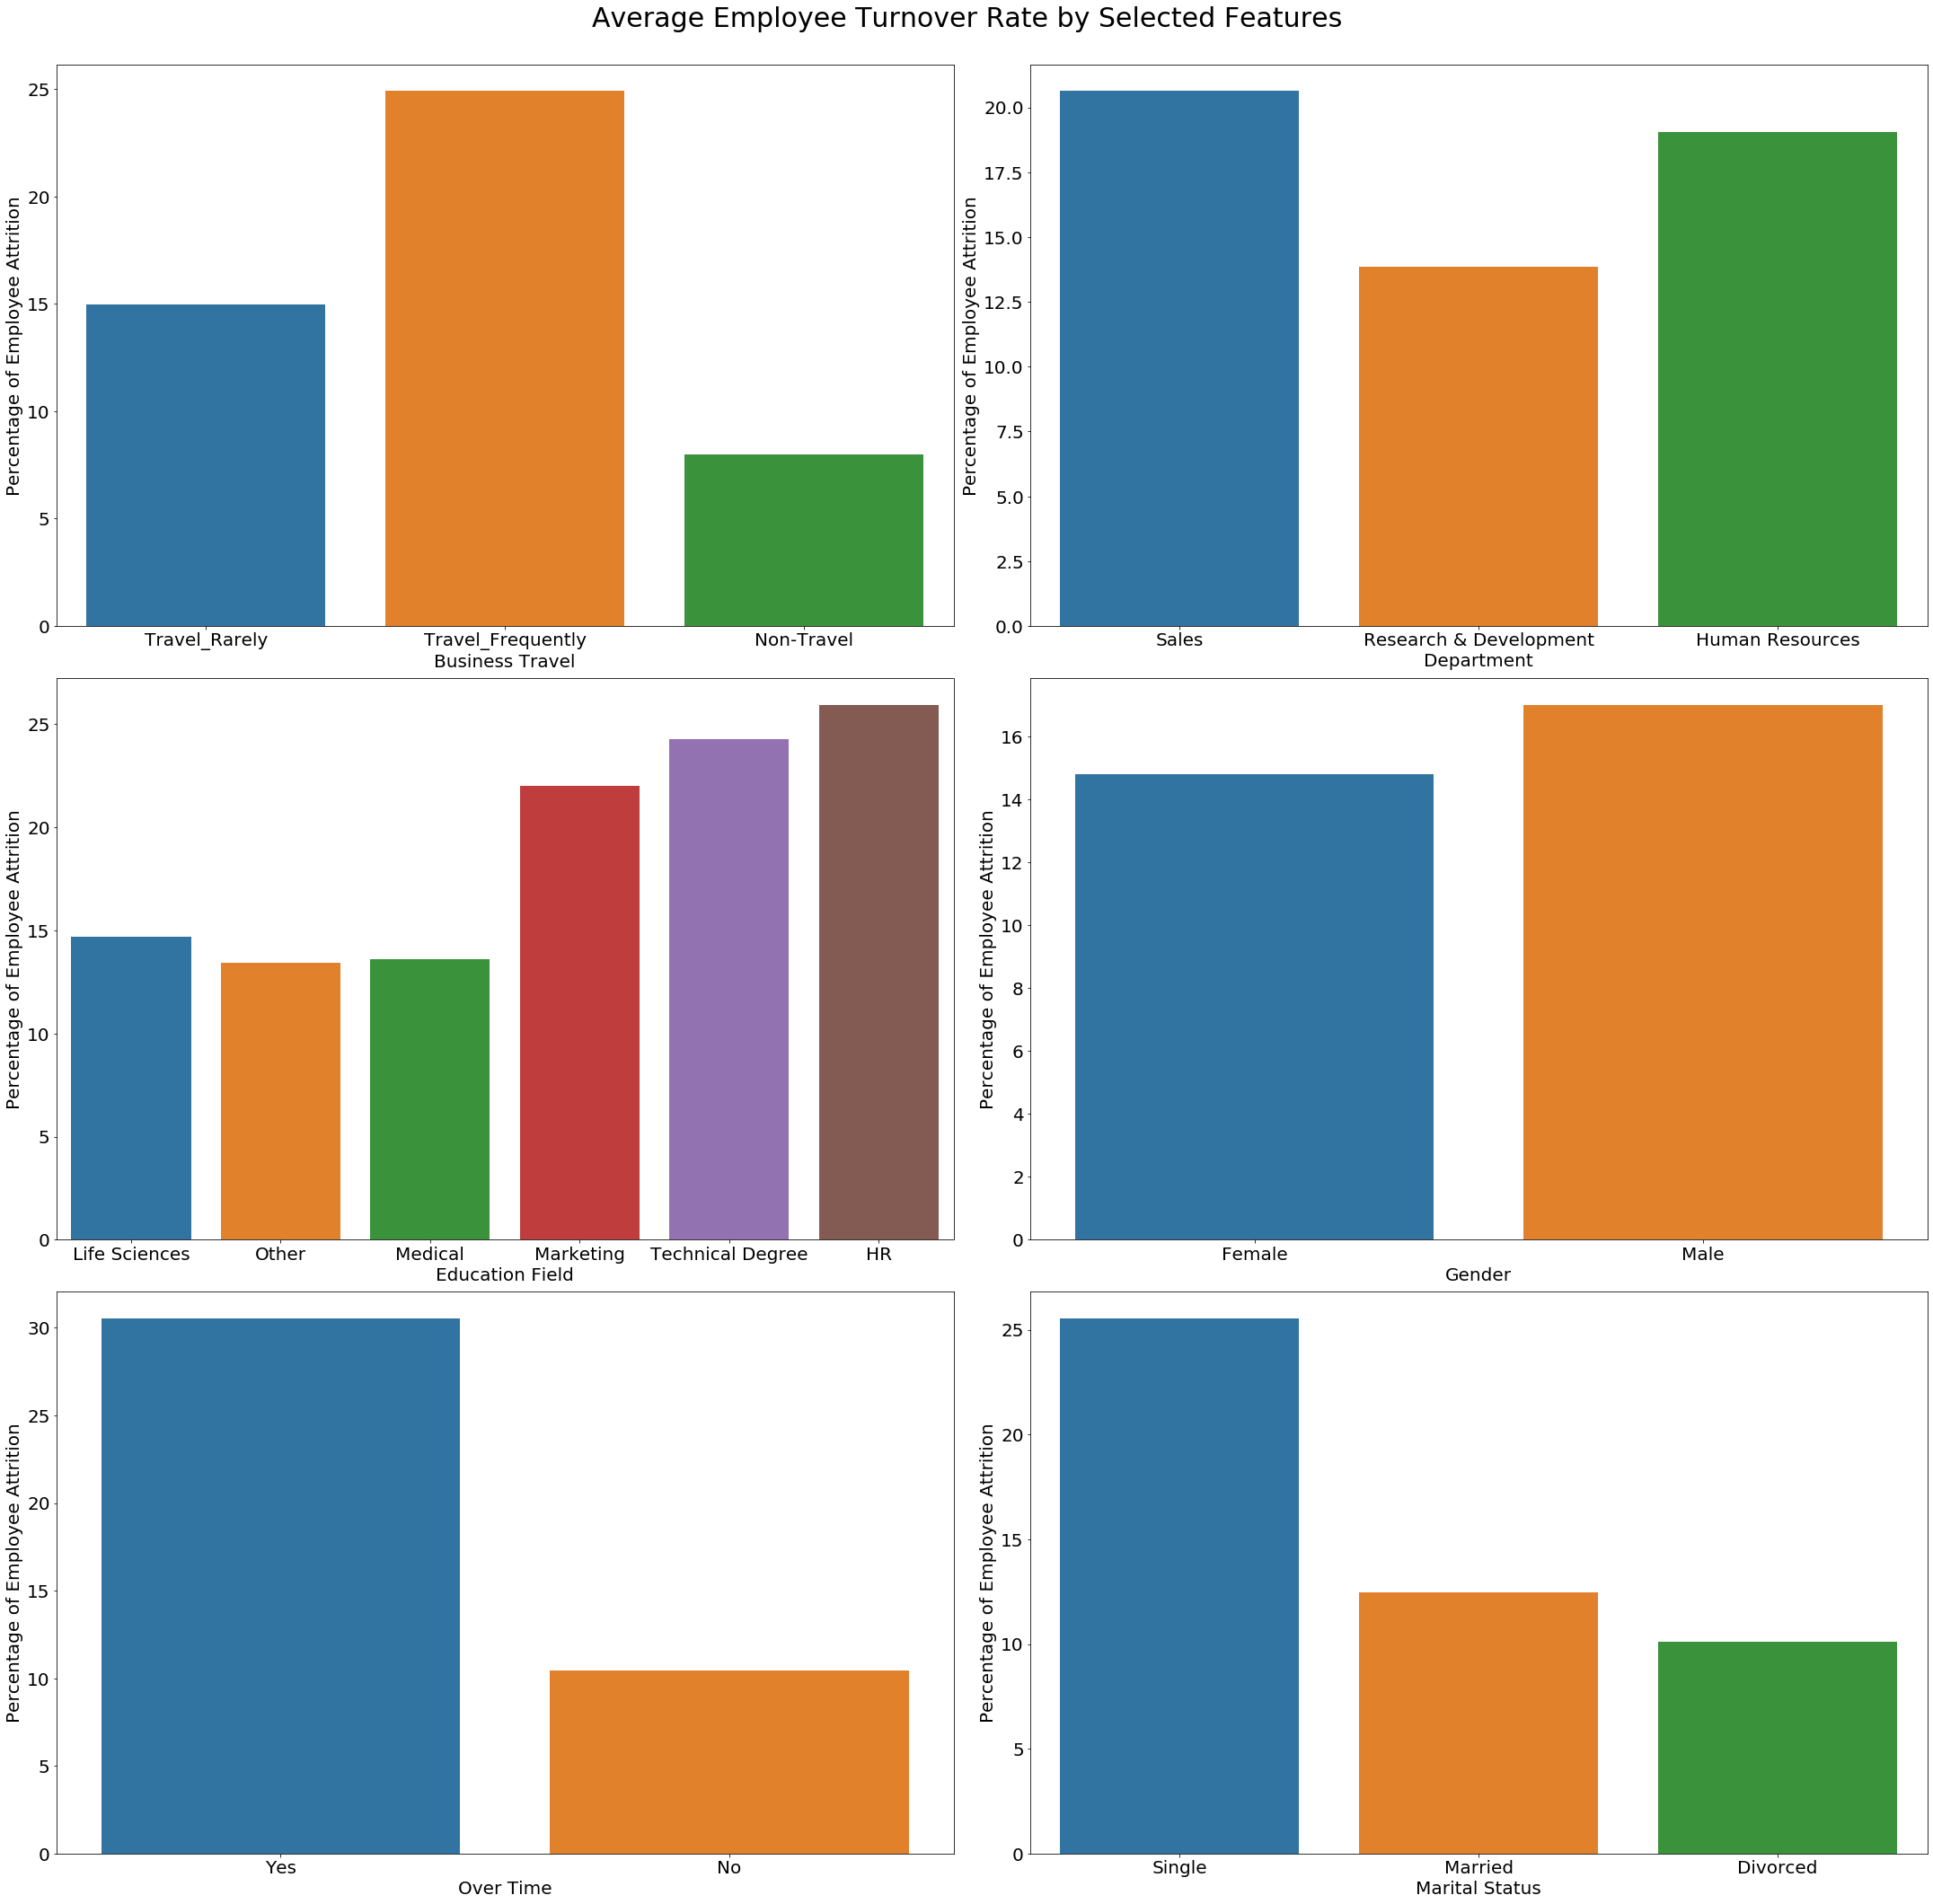

In [15]:
fig, axes = plt.subplots(3,2, figsize=(30,30))
plt.tick_params(axis='both', which='major', labelsize=20)

df['attrition_disp'] = round(df['attrition'] * 100,2)
df.loc[df['education_field'] == 'Human Resources', 'education_field'] = 'HR'

ax0 = sns.barplot(x="business_travel", y="attrition_disp", data=df, ci=False, ax = axes[0,0])
ax1 = sns.barplot(x="department", y="attrition_disp", data=df, ci=False, ax = axes[0,1])
ax2 = sns.barplot(x="education_field", y="attrition_disp", data=df, ci=False, ax = axes[1,0])
ax3 = sns.barplot(x="gender", y="attrition_disp", data=df, ci=False, ax = axes[1,1])
ax4 = sns.barplot(x="over_time", y="attrition_disp", data=df, ci=False, ax = axes[2,0])
ax5 = sns.barplot(x="marital_status", y="attrition_disp", data=df, ci=False, ax = axes[2,1])

ax0.set_ylabel('Percentage of Employee Attrition', size=20)
ax1.set_ylabel('Percentage of Employee Attrition', size=20)
ax2.set_ylabel('Percentage of Employee Attrition', size=20)
ax3.set_ylabel('Percentage of Employee Attrition', size=20)
ax4.set_ylabel('Percentage of Employee Attrition', size=20)
ax5.set_ylabel('Percentage of Employee Attrition', size=20)

ax0.set_xlabel('Business Travel', size=20)
ax1.set_xlabel('Department', size=20)
ax2.set_xlabel('Education Field', size=20)
ax3.set_xlabel('Gender', size=20)
ax4.set_xlabel('Over Time', size=20)
ax5.set_xlabel('Marital Status', size=20)

ax0.xaxis.set_tick_params(labelsize=20), ax0.yaxis.set_tick_params(labelsize=20)
ax1.xaxis.set_tick_params(labelsize=20), ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20), ax2.yaxis.set_tick_params(labelsize=20)
ax3.xaxis.set_tick_params(labelsize=20), ax3.yaxis.set_tick_params(labelsize=20)
ax4.xaxis.set_tick_params(labelsize=20), ax4.yaxis.set_tick_params(labelsize=20)
ax5.xaxis.set_tick_params(labelsize=20), ax5.yaxis.set_tick_params(labelsize=20)

fig.suptitle('Average Employee Turnover Rate by Selected Features',size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.95);

The following conditions are associated with higher attrition rates:
* Frequent travel
* Membership in the Sales department
* Education in the marketing, technical, or human resources fields
* Male gender
* Over time work
* Single marital status

The interactions between travel frequency and department show that employees in the Sales and Human Resources department who travel frequently have an average attrition rate close to 35% significantly higher than the attrition rate among all employees (16%).

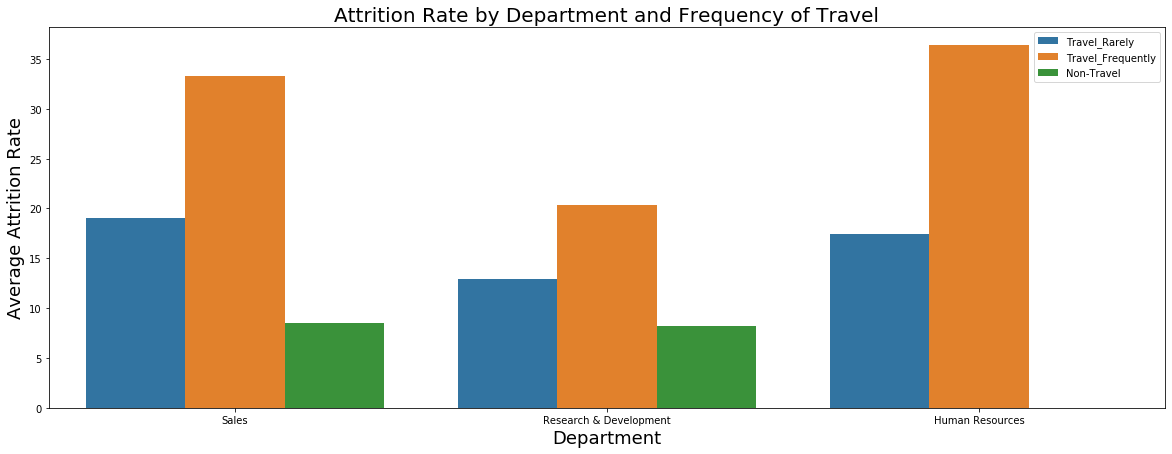

In [16]:
plt.figure(figsize=(20,7))
sns.barplot(x="department", y="attrition_disp", data=df, ci=False, hue='business_travel')
plt.title('Attrition Rate by Department and Frequency of Travel',size=20)
plt.ylabel('Average Attrition Rate',size=18)
plt.xlabel('Department',size=18)
plt.legend();

Single employees who work over time have an attrition rate close to 50%, significantly higher compared to all other marital status categories among employees who work over time and those who do not.

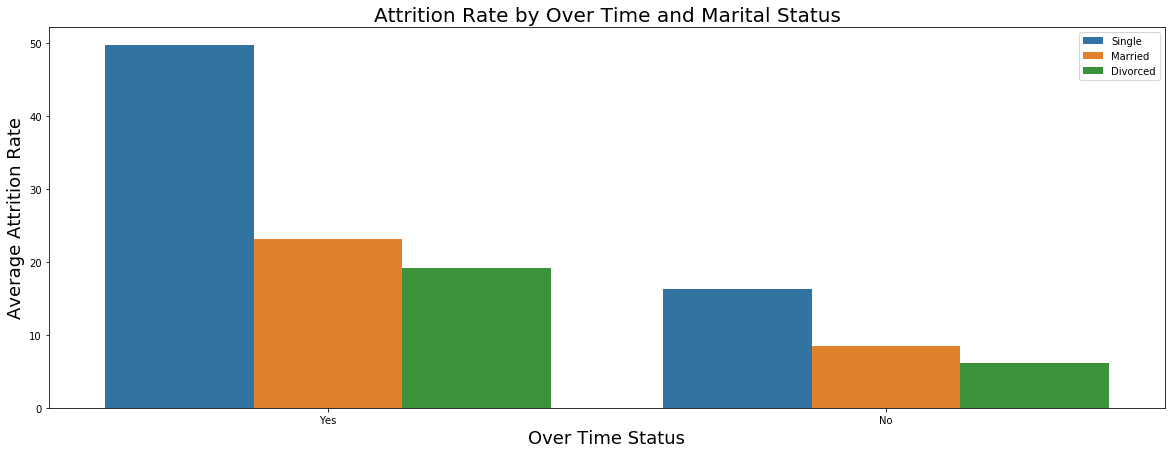

In [17]:
plt.figure(figsize=(20,7))
sns.barplot(x="over_time", y="attrition_disp", data=df, ci=False, hue='marital_status')
plt.title('Attrition Rate by Over Time and Marital Status',size=20)
plt.ylabel('Average Attrition Rate',size=18)
plt.xlabel('Over Time Status',size=18)
plt.legend();

Certain job roles such as `Sales Representative`, `Human Resources`, and `Laboratory Technician` are also associated with higher attrition rates.

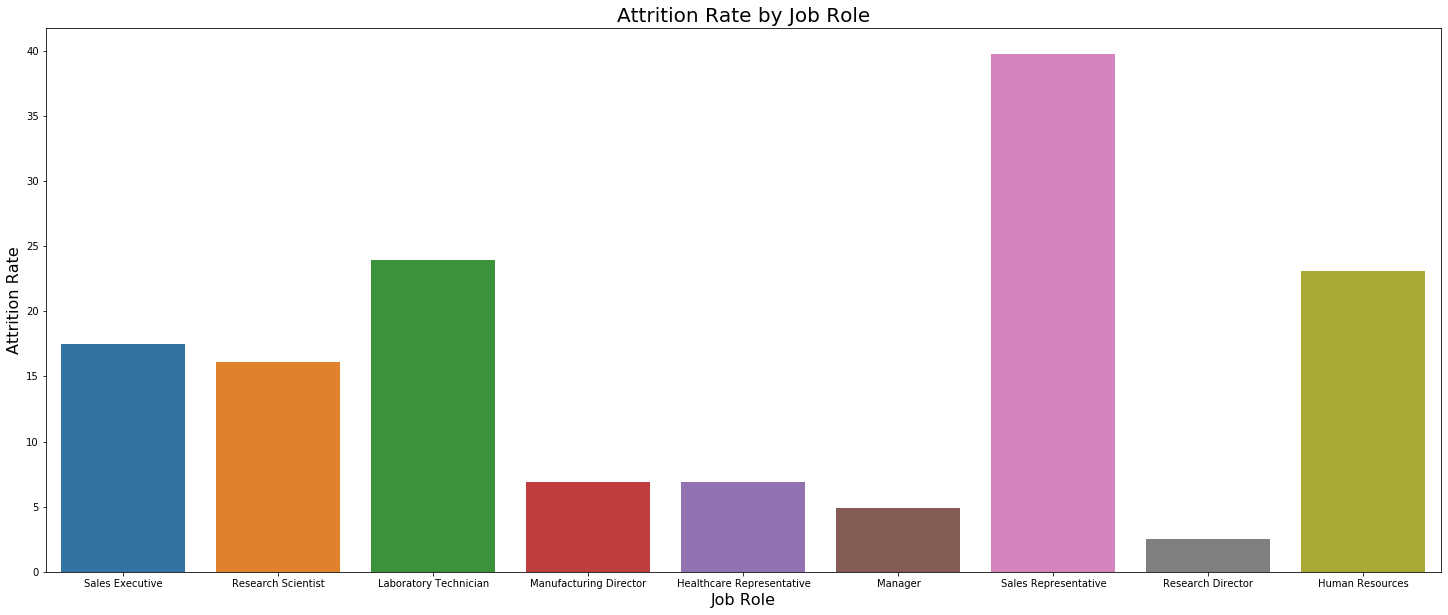

In [18]:
plt.figure(figsize=(25,10))
sns.barplot(x="job_role", y="attrition_disp", data=df, ci=False)
plt.title('Attrition Rate by Job Role', size=20)
plt.ylabel('Attrition Rate',size=16)
plt.xlabel('Job Role',size=16);

### Examine the relationship between the attrition rate and ordinal job satisfaction measures

The relative frequencies of these features indicate that most employees reported medium to high job satisfaction, environmental satisfaction, work relationship satisfaction, and work-life balance. However, only 10% of employees reported the highest level of work life balance.

In [19]:
for var in ["job_satisfaction","environment_satisfaction","relationship_satisfaction","work_life_balance"]:
    print("=============")
    print(var)
    print("=============")
    print(df[var].value_counts(normalize=True).sort_index())
    print("=============")

job_satisfaction
1    0.196599
2    0.190476
3    0.300680
4    0.312245
Name: job_satisfaction, dtype: float64
environment_satisfaction
1    0.193197
2    0.195238
3    0.308163
4    0.303401
Name: environment_satisfaction, dtype: float64
relationship_satisfaction
1    0.187755
2    0.206122
3    0.312245
4    0.293878
Name: relationship_satisfaction, dtype: float64
work_life_balance
1    0.054422
2    0.234014
3    0.607483
4    0.104082
Name: work_life_balance, dtype: float64


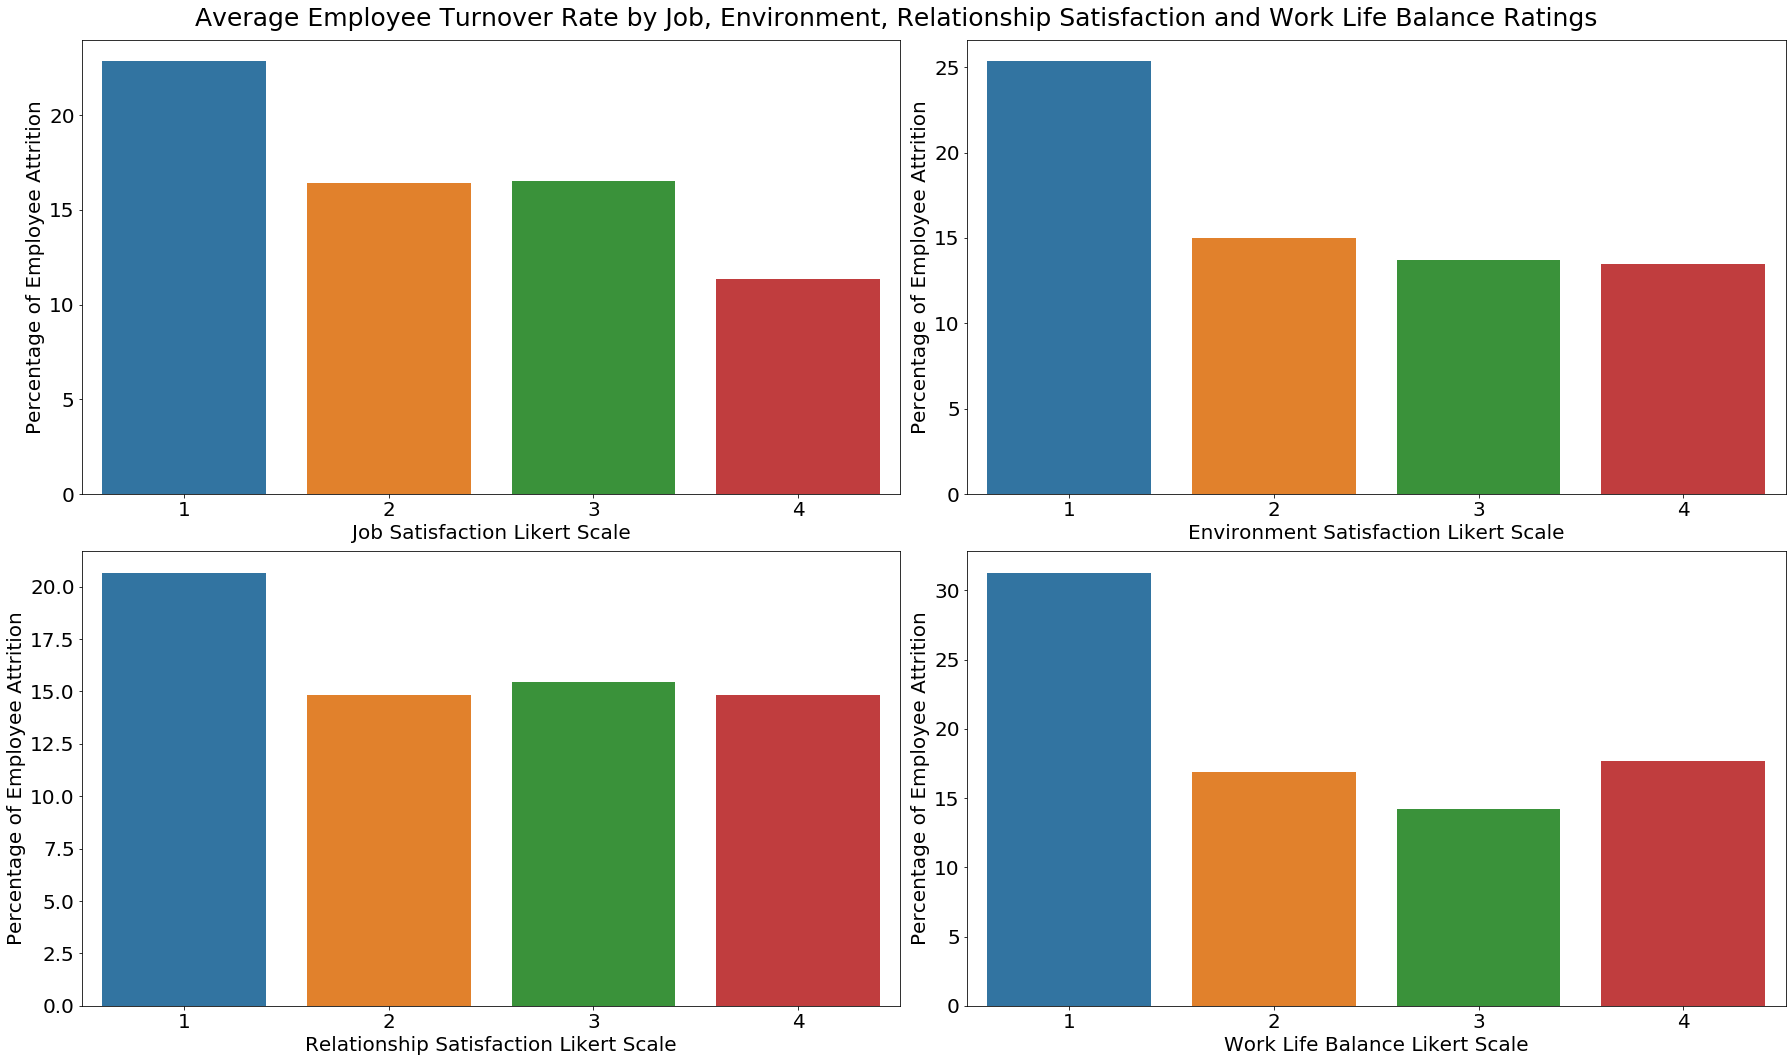

In [20]:
fig, axes = plt.subplots(2,2, figsize=(25,15))
ax0 = sns.barplot(x="job_satisfaction", y="attrition_disp", data=df, ci=False, ax = axes[0,0])
ax1 = sns.barplot(x="environment_satisfaction", y="attrition_disp", data=df, ci=False, ax = axes[0,1])
ax2 = sns.barplot(x="relationship_satisfaction", y="attrition_disp", data=df, ci=False, ax = axes[1,0])
ax3 = sns.barplot(x="work_life_balance", y="attrition_disp", data=df, ci=False, ax = axes[1,1])

ax0.set_ylabel('Percentage of Employee Attrition', size=20)
ax1.set_ylabel('Percentage of Employee Attrition', size=20)
ax2.set_ylabel('Percentage of Employee Attrition', size=20)
ax3.set_ylabel('Percentage of Employee Attrition', size=20)
ax0.set_xlabel('Job Satisfaction Likert Scale', size=20)
ax1.set_xlabel('Environment Satisfaction Likert Scale', size=20)
ax2.set_xlabel('Relationship Satisfaction Likert Scale', size=20)
ax3.set_xlabel('Work Life Balance Likert Scale', size=20)

ax0.xaxis.set_tick_params(labelsize=20), ax0.yaxis.set_tick_params(labelsize=20)
ax1.xaxis.set_tick_params(labelsize=20), ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20), ax2.yaxis.set_tick_params(labelsize=20)
ax3.xaxis.set_tick_params(labelsize=20), ax3.yaxis.set_tick_params(labelsize=20)

fig.suptitle('Average Employee Turnover Rate by Job, Environment, Relationship Satisfaction and Work Life Balance Ratings',size = 25)
fig.tight_layout()
fig.subplots_adjust(top=0.95);

The average turnover rate appears to be lower among employees that provided higher ratings on the job, environment, relationship, and work-life balance satisfaction scales, which supports the hypothesis that these features are ratings on these aspects of job satisfaction. 

As expected, employee attrition is highest where the is the lowest satisfaction. However, among employees that reported the highest work-life balance, a higher turnover rate was observed compared to other employees who offered lower ratings on this aspect of employment satisfaction.

The features below appear to be recorded on a a likert scale between 0 to 5. A higher amount of these features is understood to be a better value and expected to reduce the chances of attrition.

In [21]:
df[['education','job_involvement','job_level','performance_rating',
    'stock_option_level','training_times_last_year']].describe().T

,count,mean,std,min,25%,50%,75%,max
education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.0,5.0
job_involvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.0,4.0
job_level,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.0,5.0
performance_rating,1470.0,3.153741,0.360824,3.0,3.0,3.0,3.0,4.0
stock_option_level,1470.0,0.793878,0.852077,0.0,0.0,1.0,1.0,3.0
training_times_last_year,1470.0,2.799320,1.289271,0.0,2.0,3.0,3.0,6.0


The job level feature can be understood as an ordinal feature. A higher job level is related to a higher monthly income. Higher job levels imply higher levels of experience.

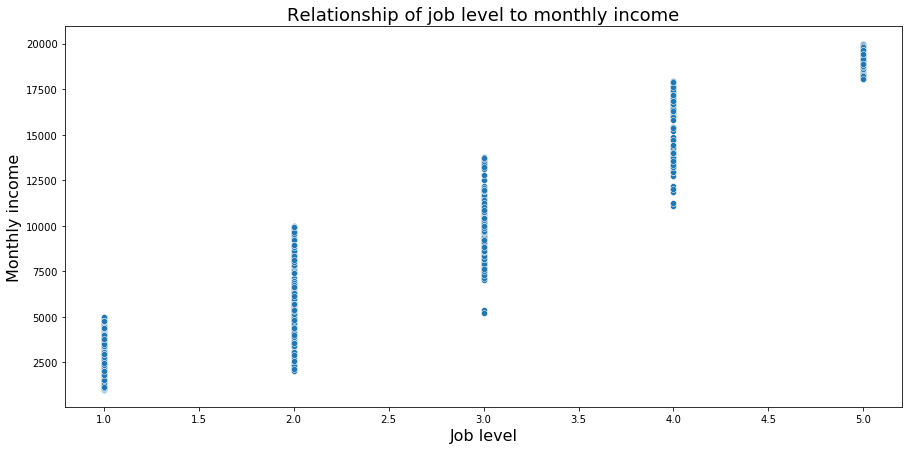

In [22]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df,x='job_level',y='monthly_income')
plt.title('Relationship of job level to monthly income', size=18)
plt.ylabel('Monthly income',size=16)
plt.xlabel('Job level', size=16);

The tabulations below present the average attrition rate by ordinal features. There is no variation in the average attrition rate by `performance_rating`. Most values in this feature are `3's`; therefore, this feature can be excluded from the analysis. All other features' values correspond to varying degrees of attrition and may be candidates for the models.

In [23]:
for feature in ['education','job_involvement','job_level','performance_rating',
                'stock_option_level','training_times_last_year']:
    print("=============")
    print(df.groupby(feature)['attrition'].mean())
    print("=============")

education
1    0.182353
2    0.156028
3    0.173077
4    0.145729
5    0.104167
Name: attrition, dtype: float64
job_involvement
1    0.337349
2    0.189333
3    0.144009
4    0.090278
Name: attrition, dtype: float64
job_level
1    0.263352
2    0.097378
3    0.146789
4    0.047170
5    0.072464
Name: attrition, dtype: float64
performance_rating
3    0.160772
4    0.163717
Name: attrition, dtype: float64
stock_option_level
0    0.244057
1    0.093960
2    0.075949
3    0.176471
Name: attrition, dtype: float64
training_times_last_year
0    0.277778
1    0.126761
2    0.179159
3    0.140530
4    0.211382
5    0.117647
6    0.092308
Name: attrition, dtype: float64


In [24]:
df.drop(columns=['performance_rating'],inplace=True)

### Examine the relationship of the attrition rate with continuous features.

* The `age` feature follows an approximately normal distribution with the mean and median both close to 36 years old
* The distance from home is skewed to the right, with a minimum of 1 mile away from home and a maximum of 29 miles
* The monthly income is skewed to the right, with most employees earning between `$2,500` and `$7,500` dollars a month
* The percent of salary increase is skewed to the right, with most employees having had a raise between 11% and 18% and some having a raise as high as 25%
* The number of years at the company is skewed to the right, with most employees having been employed between less than 1 year to 10 years and some as high as 40 years
* The years in the current role and with current manager both follow a similar distribution that is skewed to the right, with a mean around 4 years
* The years since last promotion is skewed to the right, with most employees having their last promotion between less than 1 year ago and 2 years

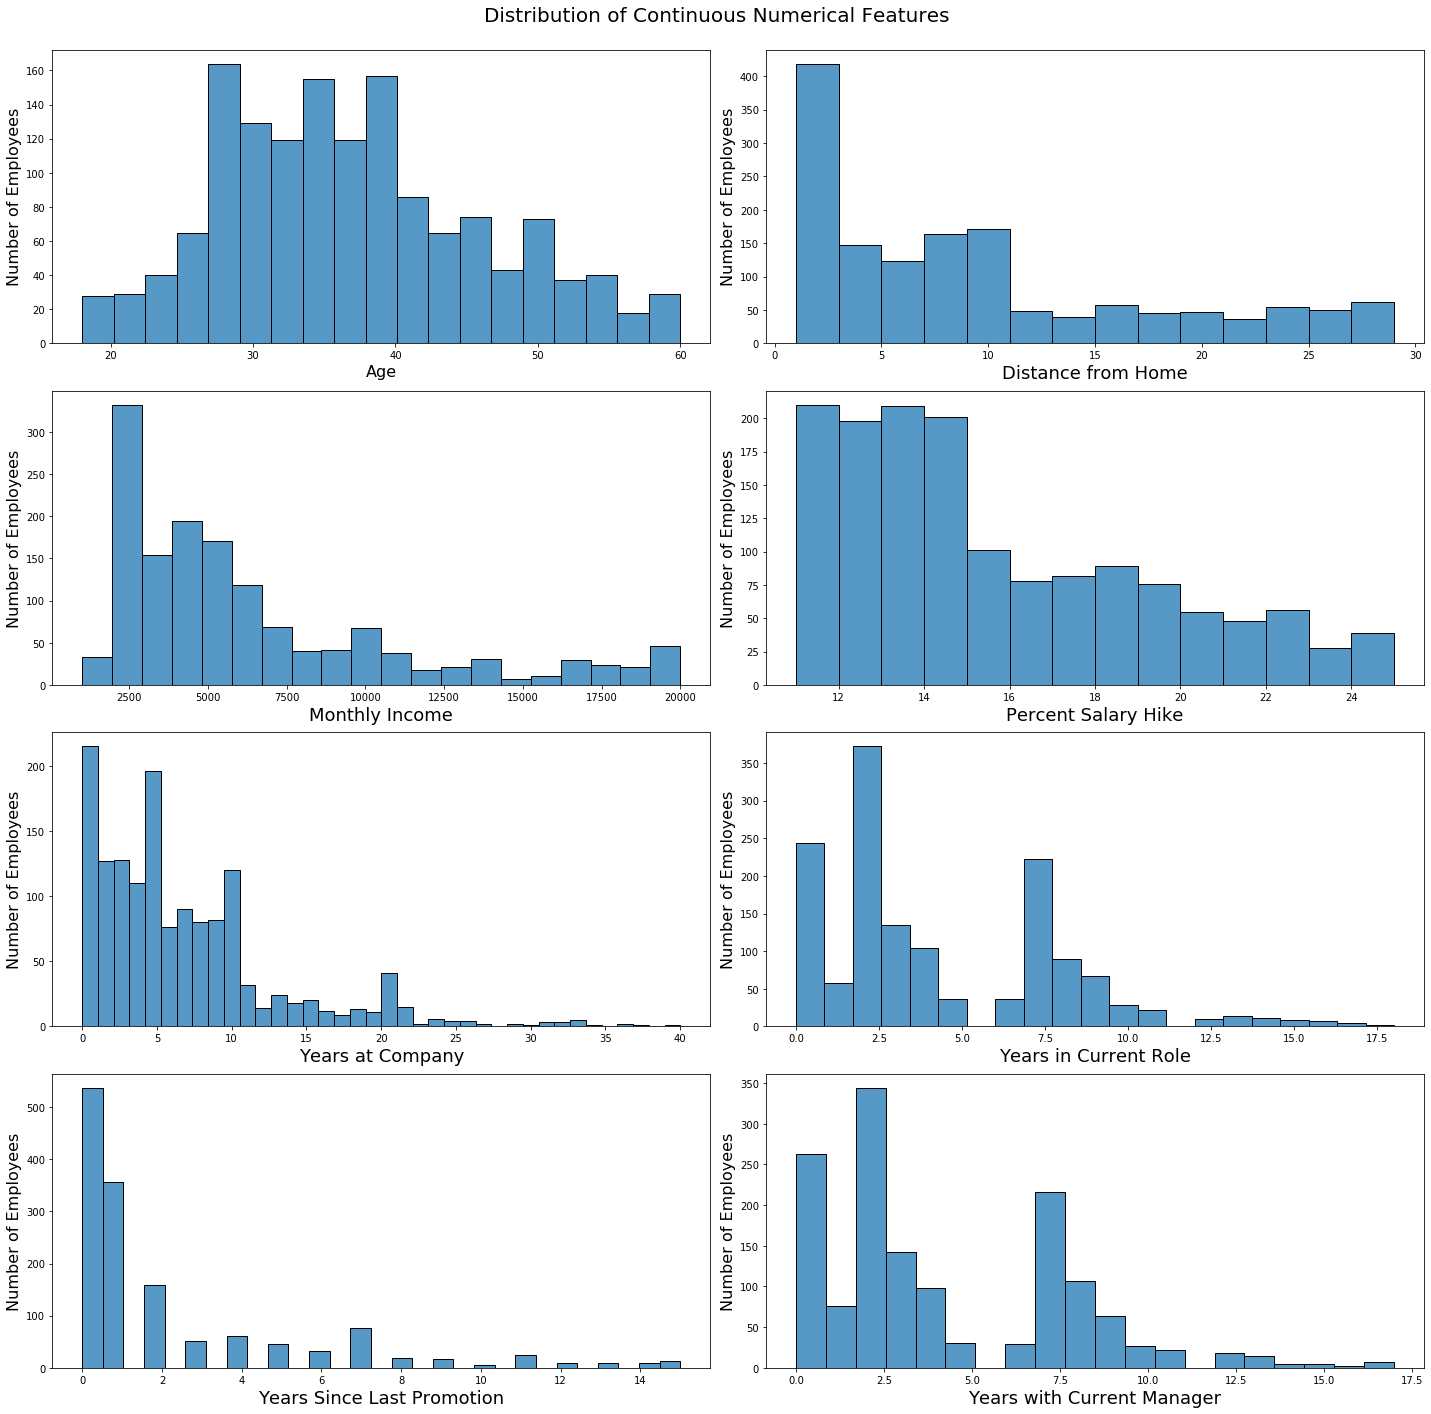

In [25]:
fig, axes = plt.subplots(4,2, figsize=(20,20))

ax0 = sns.histplot(df['age'], ax=axes[0,0])
ax1 = sns.histplot(df['distance_from_home'], ax=axes[0,1])
ax2 = sns.histplot(df['monthly_income'], ax=axes[1,0])
ax3 = sns.histplot(df['percent_salary_hike'], ax=axes[1,1])
ax4 = sns.histplot(df['years_at_company'], ax=axes[2,0])
ax5 = sns.histplot(df['years_in_current_role'],ax=axes[2,1])
ax6 = sns.histplot(df[df['years_at_company']>0]['years_since_last_promotion'],ax=axes[3,0])
ax7 = sns.histplot(df['years_with_curr_manager'],ax=axes[3,1])

ax0.set_ylabel('Number of Employees', size=16)
ax1.set_ylabel('Number of Employees', size=16)
ax2.set_ylabel('Number of Employees', size=16)
ax3.set_ylabel('Number of Employees', size=16)
ax4.set_ylabel('Number of Employees', size=16)
ax5.set_ylabel('Number of Employees', size=16)
ax6.set_ylabel('Number of Employees', size=16)
ax7.set_ylabel('Number of Employees', size=16)

ax0.set_xlabel('Age', size=16)
ax1.set_xlabel('Distance from Home', size=18)
ax2.set_xlabel('Monthly Income', size=18)
ax3.set_xlabel('Percent Salary Hike', size=18)
ax4.set_xlabel('Years at Company', size=18)
ax5.set_xlabel('Years in Current Role', size=18)
ax6.set_xlabel('Years Since Last Promotion', size=18)
ax7.set_xlabel('Years with Current Manager', size=18)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Distribution of Continuous Numerical Features', size=20);

From the breakdown of these features by the attrition rate below, it is apparent that compared to employees who remain with the company, employees who leave their jobs on average:
* Are younger by four years
* Work farther away from home
* Earn $2,046 less than thier counterparts
* Have less stock option levels
* Have worked less years in their professional careers, at the company, with their current managers, and in their current role
* Have participated in less trainings over the last year

In [26]:
df.groupby('attrition')['age','distance_from_home','monthly_income','num_companies_worked',
                        'percent_salary_hike','total_working_years','years_in_current_role',
                        'years_at_company','years_with_curr_manager','training_times_last_year'].agg(['median','mean']).T

attrition                                  0            1
age                      median    36.000000    32.000000
                         mean      37.561233    33.607595
distance_from_home       median     7.000000     9.000000
                         mean       8.915653    10.632911
monthly_income           median  5204.000000  3202.000000
                         mean    6832.739659  4787.092827
num_companies_worked     median     2.000000     1.000000
                         mean       2.645580     2.940928
percent_salary_hike      median    14.000000    14.000000
                         mean      15.231144    15.097046
total_working_years      median    10.000000     7.000000
                         mean      11.862936     8.244726
years_in_current_role    median     3.000000     2.000000
                         mean       4.484185     2.902954
years_at_company         median     6.000000     3.000000
                         mean       7.369019     5.130802
years_with_curr_manager  median     3.000000     2.000000
                         mean       4.367397     2.852321
training_times_last_year median     3.000000     2.000000
                         mean       2.832928     2.624473

Generate dummy variables of categorical features to be used in the analysis.

Prior to generating dummy variables, keep department name nad job role features for later use in survival analysis.

In [27]:
df['department_disp'] = df['department']
df['job_role_disp'] = df['job_role']

In [28]:
df = pd.get_dummies(df, columns = [col for col in df.columns if df[col].dtypes == 'O' and '_disp' not in col], drop_first=True)

Create interaction terms between features.

In [29]:
df['sales_travel_freq'] = df['department_Sales'] * df['business_travel_Travel_Frequently']

In [30]:
df['over_time_single'] = df['over_time_Yes'] * df['marital_status_Single']

Convert the `job_satisfaction`, `environment_satisfaction`, `relationship_satisfaction`, and `work_life_balance` features to binary variables for low or medium employee satisfaction ratings in these areas.

In [31]:
for feature in ['job_satisfaction','environment_satisfaction','relationship_satisfaction','work_life_balance']:
    df[feature] = df[feature].apply(lambda x: 1 if x < 2 else 0)

## Modeling

Estimate attrition using logistic regression, K-nearest neighbors, Random Forest, Gradient Boosting classifiers. Using these estimators, create a model that will maximize:

* Precision: the proportion of true predictions of employee attrition out of all predictions of attrition
* Recall: the proportion of true cases of employee attrition out of all true cases of employee attrition

Also, using a Receiver Operating Characteristic (ROC) curve, maximize the true positive rate while minimizing the false positive rate.

This evaluation will help Human Resources departments correctly identify employees at higher risk of attrition.

### Binary Classification with Logistic Regression

The baseline model is based on the class majority, which is the negative class of employee retention. The baseline model reflects an accuracy of 84%.

In [32]:
df['attrition'].value_counts(normalize=True)

0    0.838776
1    0.161224
Name: attrition, dtype: float64

Define the vector of employee features and the target feature.

In [33]:
X = df.drop(columns=['attrition','department_disp','job_role_disp','attrition_disp'])
y = df['attrition']

Split the data into a training and testing data set and use a grid search to find the hyper parameters that will produce the best accuracy score.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Standardize the data.

In [35]:
ss = StandardScaler()

In [36]:
Xs_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)
Xs_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [37]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(Xs_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [38]:
print("Training Data Set Classification Results")
print(classification_report(y_train, lr.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, lr.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, lr.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, lr.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       924
           1       0.82      0.50      0.62       178

    accuracy                           0.90      1102
   macro avg       0.87      0.74      0.78      1102
weighted avg       0.90      0.90      0.89      1102

The AUC score for the training data set is: 0.7397186147186147
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       309
           1       0.62      0.41      0.49        59

    accuracy                           0.86       368
   macro avg       0.75      0.68      0.71       368
weighted avg       0.85      0.86      0.85       368

The AUC score for the testing data set is: 0.6791179858482804


The output above shows that the precision score in the training data set is 82% and the recall score is 50% in the testing data set. In the testing data set, these scores are 62% and 41%, respectively. The model with the highest Area Under the Curve (AUC) score in the testing data set is the best model because it provides the highest true positive and false positive rate combination in the unseen data.

#### Evaluate if adjusting the hyperparameters of the `LogisticRegression()` estimator will improve the classification results.

Set up a pipe for the StandardScaler transformer and LogisticRegression estimator.

In [39]:
pipe = Pipeline([('ss', StandardScaler()),('lr', LogisticRegression())])

pipe_params = {'ss__with_mean': [True,False],
              'ss__with_std': [True,False],
              'lr__penalty': ['l1','l2'],
              'lr__C': np.logspace(-4, 4, 4),
              'lr__solver': ['lbfgs', 'liblinear']}

In [40]:
pipe_grid_search = GridSearchCV(pipe, pipe_params, cv=5, verbose=1)
pipe_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['lbfgs', 'liblinear'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [41]:
print("The best accuracy score on the training data set is:", round(pipe_grid_search.best_score_,2))
print("The accuracy score on the testing data set is:",pipe_grid_search.score(X_test,y_test))
print("The best estimator is:", pipe_grid_search.best_estimator_)
print("The best parameters are:",pipe_grid_search.best_params_)

The best accuracy score on the training data set is: 0.89
The accuracy score on the testing data set is: 0.8722826086956522
The best estimator is: Pipeline(steps=[('ss', StandardScaler()),
                ('lr', LogisticRegression(C=0.046415888336127774))])
The best parameters are: {'lr__C': 0.046415888336127774, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'ss__with_mean': True, 'ss__with_std': True}


Fit the model with the hyperparameters found using the grid search.

In [42]:
lr = LogisticRegression(penalty='l2', solver = 'lbfgs', C=0.046415888336127774)
lr.fit(Xs_train, y_train)

LogisticRegression(C=0.046415888336127774)

In [43]:
print("Training Data Set Classification Results")
print(classification_report(y_train, lr.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, lr.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, lr.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, lr.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       924
           1       0.88      0.40      0.55       178

    accuracy                           0.89      1102
   macro avg       0.89      0.69      0.74      1102
weighted avg       0.89      0.89      0.88      1102

The AUC score for the training data set is: 0.6940269468359356
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       309
           1       0.69      0.37      0.48        59

    accuracy                           0.87       368
   macro avg       0.79      0.67      0.71       368
weighted avg       0.86      0.87      0.86       368

The AUC score for the testing data set is: 0.6702594481926388


The hyper-parameters without the grid search will be used because they return the highest AUC score and the highest recall score in the testing data set, which best represents unseen data by the model.

#### Use cross-validation to identify how the results vary depending on combinations of train-test splits.

Using a pipeline to standardize the features prior to fitting each logistic regression model, use cross validation to find the accuracy, precision, and recall scores.

In [44]:
pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', LogisticRegression(penalty='l1', solver='liblinear'))])
print("The accuracy score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'accuracy').mean())
print("The precision score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'precision').mean())
print("The recall score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'recall').mean())

The accuracy score is: 0.8809523809523808
The precision score is: 0.7218386241122615
The recall score is: 0.42624113475177305


### Classification with K-nearest neighbors classifiers

In [45]:
knn = KNeighborsClassifier()
knn.fit(Xs_train, y_train)

KNeighborsClassifier()

In [46]:
print("Training Data Set Classification Results")
print(classification_report(y_train, knn.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, knn.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, knn.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, knn.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       924
           1       0.79      0.28      0.41       178

    accuracy                           0.87      1102
   macro avg       0.83      0.63      0.67      1102
weighted avg       0.86      0.87      0.84      1102

The AUC score for the training data set is: 0.6306058174035701
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       309
           1       0.53      0.15      0.24        59

    accuracy                           0.84       368
   macro avg       0.69      0.56      0.57       368
weighted avg       0.80      0.84      0.80       368

The AUC score for the testing data set is: 0.5633262026219078


Use a grid search to identify the best model hyperparameters for this classifier.

In [47]:
pipe = Pipeline([('ss', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

pipe_params = {'ss__with_mean': [True,False],
              'ss__with_std': [True,False],
              'knn__n_neighbors': range(3,10,1),
              'knn__p': [1,2],
              'knn__weights': ['uniform', 'distance']}

In [48]:
pipe_grid_search = GridSearchCV(pipe, pipe_params, cv=5, verbose=1)
pipe_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(3, 10), 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [49]:
print("The best accuracy score on the training data set is:", round(pipe_grid_search.best_score_,2))
print("The accuracy score on the testing data set is:",pipe_grid_search.score(X_test,y_test))
print("The best estimator is:", pipe_grid_search.best_estimator_)
print("The best parameters are:",pipe_grid_search.best_params_)

The best accuracy score on the training data set is: 0.86
The accuracy score on the testing data set is: 0.8532608695652174
The best estimator is: Pipeline(steps=[('ss', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9, p=1))])
The best parameters are: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform', 'ss__with_mean': True, 'ss__with_std': True}


In [50]:
knn = KNeighborsClassifier(n_neighbors=9,p=1,weights='uniform')
knn.fit(Xs_train,y_train)

KNeighborsClassifier(n_neighbors=9, p=1)

In [51]:
print("Training Data Set Classification Results")
print(classification_report(y_train, knn.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, knn.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, knn.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, knn.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       924
           1       0.82      0.19      0.30       178

    accuracy                           0.86      1102
   macro avg       0.84      0.59      0.61      1102
weighted avg       0.86      0.86      0.82      1102

The AUC score for the training data set is: 0.5889087504256044
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       309
           1       0.69      0.15      0.25        59

    accuracy                           0.85       368
   macro avg       0.78      0.57      0.58       368
weighted avg       0.83      0.85      0.81       368

The AUC score for the testing data set is: 0.569798694531293


#### Use cross-validation to identify how the results vary depending on combinations of train-test splits.

In [52]:
pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', KNeighborsClassifier())])
print("The accuracy score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'accuracy').mean())
print("The precision score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'precision').mean())
print("The recall score is:",cross_val_score(pipeline, X, y, cv = 5, scoring = 'recall').mean())

The accuracy score is: 0.8448979591836736
The precision score is: 0.5832449903038139
The recall score is: 0.14796099290780143


#### Classification with random forest classifier

In [53]:
rf = RandomForestClassifier()
rf.fit(Xs_train,y_train)

RandomForestClassifier()

In [54]:
print("Training Data Set Classification Results")
print(classification_report(y_train, rf.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, rf.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, rf.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, rf.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       924
           1       1.00      1.00      1.00       178

    accuracy                           1.00      1102
   macro avg       1.00      1.00      1.00      1102
weighted avg       1.00      1.00      1.00      1102

The AUC score for the training data set is: 1.0
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       309
           1       0.63      0.20      0.31        59

    accuracy                           0.85       368
   macro avg       0.75      0.59      0.61       368
weighted avg       0.83      0.85      0.82       368

The AUC score for the testing data set is: 0.5903680544128134


Use a grid search to identify the best model hyperparameters for this classifier.

In [55]:
pipe = Pipeline([('ss', StandardScaler()),
                 ('rf', RandomForestClassifier(n_jobs=-1,random_state=42))])

pipe_params = {'ss__with_mean': [True,False],
              'ss__with_std': [True,False],
              'rf__n_estimators': range(100,500,50)}

pipe_grid_search = GridSearchCV(pipe, pipe_params, cv=5, verbose=1)

pipe_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__n_estimators': range(100, 500, 50),
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [56]:
print("The best accuracy score on the training data set is:", round(pipe_grid_search.best_score_,2))
print("The accuracy score on the testing data set is:",pipe_grid_search.score(Xs_test,y_test))
print("The best estimator is:", pipe_grid_search.best_estimator_)
print("The best parameters are:",pipe_grid_search.best_params_)

The best accuracy score on the training data set is: 0.87
The accuracy score on the testing data set is: 0.5027173913043478
The best estimator is: Pipeline(steps=[('ss', StandardScaler(with_mean=False, with_std=False)),
                ('rf',
                 RandomForestClassifier(n_estimators=150, n_jobs=-1,
                                        random_state=42))])
The best parameters are: {'rf__n_estimators': 150, 'ss__with_mean': False, 'ss__with_std': False}


In [57]:
rf = RandomForestClassifier(n_estimators=150)
rf.fit(Xs_train,y_train)

RandomForestClassifier(n_estimators=150)

In [58]:
print("Training Data Set Classification Results")
print(classification_report(y_train, rf.predict(Xs_train)))
print("The AUC score for the training data set is:",roc_auc_score(y_train, rf.predict(Xs_train)))
print("========================================")
print("Testing Data Set Classification Results")
print(classification_report(y_test, rf.predict(Xs_test)))
print("The AUC score for the testing data set is:",roc_auc_score(y_test, rf.predict(Xs_test)))

Training Data Set Classification Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       924
           1       1.00      1.00      1.00       178

    accuracy                           1.00      1102
   macro avg       1.00      1.00      1.00      1102
weighted avg       1.00      1.00      1.00      1102

The AUC score for the training data set is: 1.0
Testing Data Set Classification Results
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       309
           1       0.53      0.15      0.24        59

    accuracy                           0.84       368
   macro avg       0.69      0.56      0.57       368
weighted avg       0.80      0.84      0.80       368

The AUC score for the testing data set is: 0.5633262026219078


#### Use cross-validation to identify how the results vary depending on combinations of train-test splits.

In [59]:
estimator = RandomForestClassifier(n_estimators=150)
print("The accuracy score is:",cross_val_score(estimator, X, y, cv = 5, scoring = 'accuracy').mean())
print("The precision score is:",cross_val_score(estimator, X, y, cv = 5, scoring = 'precision').mean())
print("The recall score is:",cross_val_score(estimator, X, y, cv = 5, scoring = 'recall').mean())

The accuracy score is: 0.8612244897959183
The precision score is: 0.7321212121212122
The recall score is: 0.1646276595744681


### Model evaluation and selection

The ROC curves plot the relationship between the true positive rate and the false positive rate. The curve farthest away from the diagonal line represents the best model because it correctly identifies true instances of employee attrition compared to other models. The logistic regression model provides the best result also demonstrated by the highest AUC score.

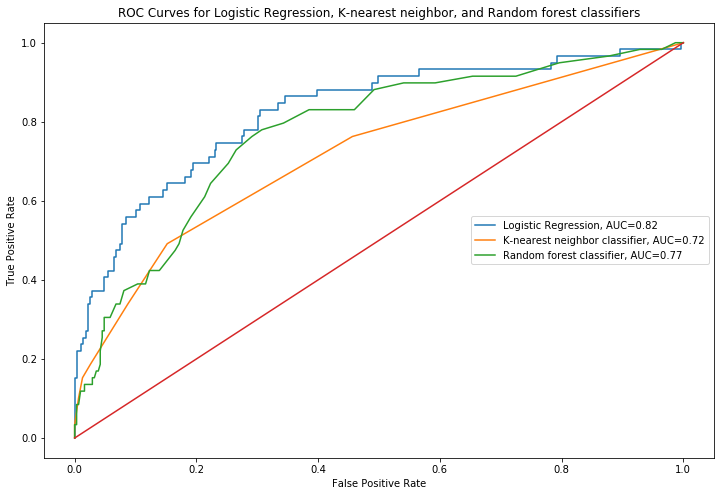

In [60]:
plt.figure(figsize=(12,8))
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(Xs_train, y_train)
y_pred = lr.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred),2)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

knn = KNeighborsClassifier(n_neighbors=9,p=1,weights='uniform')
knn.fit(Xs_train, y_train)
y_pred = knn.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred),2)
plt.plot(fpr,tpr,label="K-nearest neighbor classifier, AUC="+str(auc))

rf = RandomForestClassifier()
rf.fit(Xs_train, y_train)
y_pred = rf.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred),2)
plt.plot(fpr,tpr,label="Random forest classifier, AUC="+str(auc))
diagonal = [0.0, 1.0]
plt.plot(diagonal,diagonal)

plt.title('ROC Curves for Logistic Regression, K-nearest neighbor, and Random forest classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center right')
plt.savefig('./assets/roc.png');

After fitting multiple models also searching for the combination of hyperparameters and cross validation that produce the highest precision and recall scores, the table below summarizes the performance of each of these models.

|Estimator|Hyper-parameters|Accuracy Score |Precision Score|Recall Score
|---|---|---|---|---|
|Logistic Regression|Solver: `liblinear`; penalty: `l1`|88%|72%|43%
|k-Nearest Neighbors|Number of neighbors:9; Power parameter of Minkowski metric: 1; Weight function: uniform|84%|58%|15%
|Random Forest|Default|86%|74%|18%

The logistic regression model produces the highest accuracy, precision, and recall cross-validated scores which confirms this is the best model for the data.

In [61]:
plt.figure(figsize=(12,8))
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(StandardScaler().fit_transform(X), y)

LogisticRegression(penalty='l1', solver='liblinear')

<Figure size 864x576 with 0 Axes>

From the coefficients below, it is evident that the `l1` penalty term forced some coefficients to 0, which helps avoid overfitting in the estimation of attrition.

In [62]:
lr.coef_

array([[-0.28020395,  0.37182391,  0.00600214,  0.4582539 , -0.38623079,
        -0.0628589 ,  0.33896516,  0.        ,  0.44491071, -0.06205931,
         0.32021243, -0.18640541, -0.42289433, -0.22595805,  0.25460608,
         0.39495349, -0.45506076,  0.58718475, -0.46306849,  0.54667411,
         0.3821954 ,  0.        ,  0.08778073, -0.15184251,  0.04773237,
        -0.15060855, -0.08915206,  0.16244351,  0.16502083,  0.23058886,
         0.45630013,  0.        ,  0.02842499, -0.21197458,  0.11572556,
         0.17968485,  0.33310114,  0.07999971,  0.40177352,  0.84269279,
         0.14267897,  0.05425827]])

In [63]:
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=Xs_train.columns).T.reset_index().\
            rename(columns={'index':'Features',0:'Exponentiated Coefficient'}).\
            sort_values(by='Exponentiated Coefficient',ascending=False)

In [64]:
labels = [('over_time_Yes','Overtime work'),
          ('years_since_last_promotion','Years since last promotion'),
          ('job_role_Laboratory Technician','Job role: laboratory technician'),
          ('business_travel_Travel_Frequently','Frequent business travel'),
          ('environment_satisfaction','Low work environment satisfaction'),
          ('num_companies_worked','Number of companies worked at'),
          ('distance_from_home','Distance from home'),
          ('job_role_Sales Representative','Job role: Sales representative'),
          ('relationship_satisfaction','Low work relationships satisfaction'),
          ('business_travel_Travel_Rarely','Rare business travel'),
          ('work_life_balance','Low work-life balance satisfaction'),
          ('job_satisfaction','Low job satisfaction'),
          ('job_role_Human Resources','Job role: Human Resources'),
          ('marital_status_Single','Marital status: Single'),
          ('job_role_Sales Executive','Job role: Sales Executive'),
          ('sales_travel_freq','Frequent travel and in Sales department'),
          ('job_level','Job level'),
          ('gender_Male','Male'),
         ('over_time_single','Works over time and is single'),
         ('years_at_company','Years at company'),
         ('job_role_Research_Scientist','Job role: Research Scientist')]

In [65]:
for label in labels:
    coeffs.loc[coeffs['Features'] == label[0], 'Features'] = label[1]

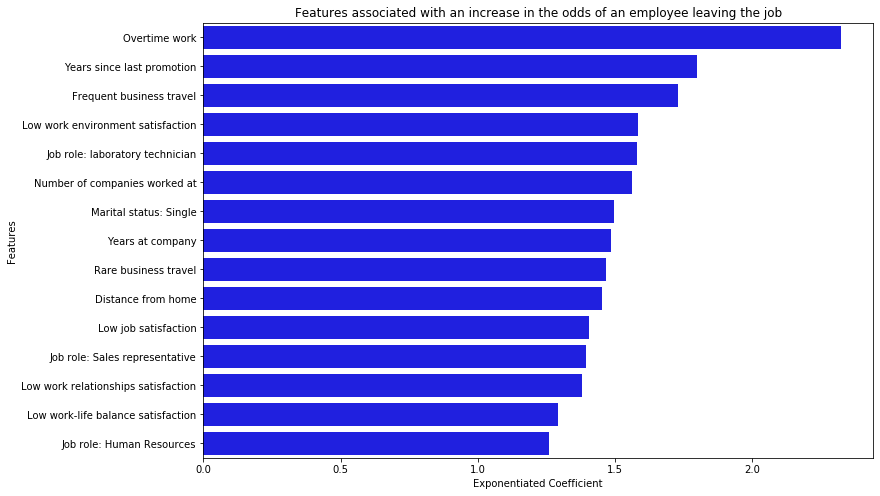

In [66]:
plt.figure(figsize=(12,8))
plt.title('Features associated with an increase in the odds of an employee leaving the job')
sns.barplot(orient='h',data=coeffs[coeffs['Exponentiated Coefficient']>=1.2], y='Features', x = 'Exponentiated Coefficient',
            color='blue')
plt.savefig('./assets/features.png');

Exponentiating the coefficients from the logistic regression using the complete data set allows computing the odds ratios of employees leaving their jobs. From the plot above focusing on the features associated a likelihood of 20% or higher of attrition, it can be seen that:

* Employees who work over time are more than twice as likely to quit their jobs than to stay
* An additional year since the last promotion increases the odds of an employee quitting by more than 50%
* Frequent business travel increases the odds of an employee quitting by more than 50% and rare business travel increases the odds by close to 50%
* Low work environment, relationship, and overall job satisfaction and work-life balance are associated with higher odds of employees leaving their jobs. These employees are significantly more likely to leave their jobs than to remain.
* An additional increase in the number of companies an individual has worked at is associated with an increase in the odds of quitting of more than 50%
* Job roles such as `laboratory technician`, `sales representative, and Human Resources` are associated with a higher likelihood of attrition.
* For every additional year at the company, the odds of an employee leaving the job increases by more than 20%

The number of years an employee has worked at the company increases the odds of attrition. As a next step in this analysis, evaluate the time when the likelihood of attrition increases significantly.

### Survival Analysis

Survival analysis is used to estimate the probability that an event happens at a given time given a set of covariates. In this case, the event predicted is employee attrition and the time to event is the year of tenure of the employee.

To visualize the probability of attrition (and conversely retention) over time, create the Kaplan Meier Curve to analyze the retention probabilities.

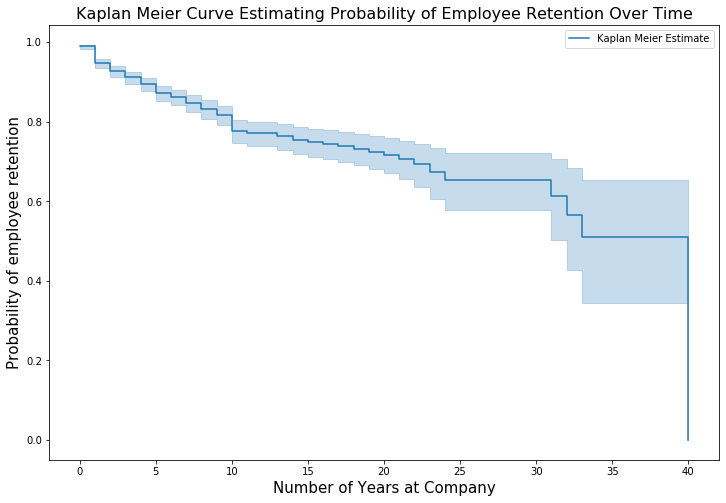

In [67]:
duration = df['years_at_company']
turnover = df['attrition']

km = KaplanMeierFitter()

km.fit(duration, turnover, label = 'Kaplan Meier Estimate')

km.plot(figsize = (12, 8))
plt.xlabel('Number of Years at Company', fontsize = 15)
plt.ylabel('Probability of employee retention', fontsize = 15)
plt.title('Kaplan Meier Curve Estimating Probability of Employee Retention Over Time', size = 16)
plt.savefig('./assets/kpc.png');

The probability of employee retention decreases over time. However, the rate of the decline appears to be faster within the first 10 years of employment and after 30 years of employment. 

Efforts can be made within the first 10 years of employee to retain employees that add value to the organization by customizing professional development plans and adjusting compensation packages to incentivize their retention. 

Given that the probability of retention declines rapidly after 30 years of service, succession plans for high value employees can be put in place to make sure institutional knowledge transfers are in place.

For a select job roles, the following can be seen from the data:
* Sales Executive jobs tend to have the lowest attrition compared to other job roles and the probability of retention becomes 0 after around 23 years fo service
* Research Scientist job roles tend to have high rates of retention and the probability of retention starts to drop sharply after 10 years of service
* Laboratory technician roles tend to have a high decline in job retention in the first five years of service decreasing from 100% to around 80%
* For Human Resources positions, after around seven years of service and up to 20 years of service, the probability of retention appears to be stable at around 70% and declines sharply to 0% after 20 years of service
* Sales Representative jobs have the largest decline in employee retention within the first five years of service

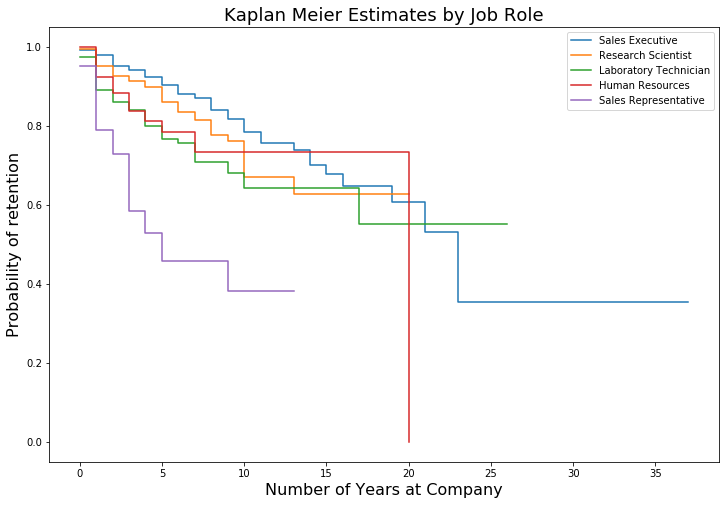

In [68]:
plt.figure(figsize=(20,10))
kmf = KaplanMeierFitter()

groups = df['job_role_disp']
group1 = (groups == 'Sales Executive')
group2 = (groups == 'Research Scientist')
group3 = (groups == 'Laboratory Technician')
group4 = (groups == 'Human Resources')
group5 = (groups == 'Sales Representative')

kmf.fit(duration[group1], turnover[group1], label = 'Sales Executive')
ax = kmf.plot(ci_show=False)

kmf.fit(duration[group2], turnover[group2], label = 'Research Scientist')
ax1 = kmf.plot(ax = ax, ci_show=False)

kmf.fit(duration[group3], turnover[group3], label = 'Laboratory Technician')
ax2 = kmf.plot(ax = ax1, ci_show=False)

kmf.fit(duration[group4], turnover[group4], label = 'Human Resources')
ax3 = kmf.plot(ax = ax2, figsize = (12, 8), ci_show=False)

kmf.fit(duration[group5], turnover[group5], label = 'Sales Representative')
ax4 = kmf.plot(ax = ax3, figsize = (12, 8), ci_show=False)

plt.title('Kaplan Meier Estimates by Job Role',size=18)
plt.xlabel('Number of Years at Company',size=16)
plt.ylabel('Probability of retention',size=16)

plt.savefig('./assets/kpc-job.png');

Evaluating the probability of retention by department, the Sales department has the highest attrition, which may be due in part to the high attrition among `Sales Representatives`. The `Research & Development` department tends to have the lowest attrition rates among all departments in the first ten years of service.

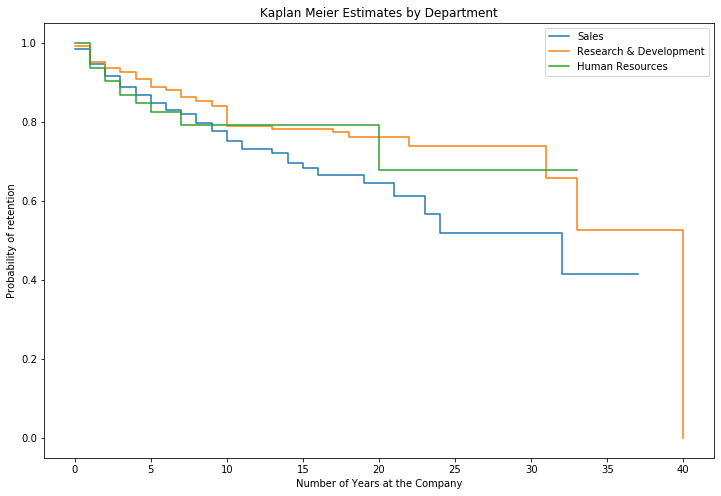

In [69]:
plt.figure(figsize=(20,10))
kmf = KaplanMeierFitter()

groups = df['department_disp']
group1 = (groups == 'Sales')
group2 = (groups == 'Research & Development')
group3 = (groups == 'Human Resources')

kmf.fit(duration[group1], turnover[group1], label = 'Sales')
ax = kmf.plot(ci_show=False)

kmf.fit(duration[group2], turnover[group2], label = 'Research & Development')
ax1 = kmf.plot(ax = ax, ci_show=False)

kmf.fit(duration[group3], turnover[group3], label = 'Human Resources')
ax2 = kmf.plot(ax = ax1, figsize = (12, 8), ci_show=False)

plt.title('Kaplan Meier Estimates by Department')
plt.xlabel('Number of Years at the Company')
plt.ylabel('Probability of retention');

In [70]:
cph = CoxPHFitter()

cph.fit(df[['business_travel_Travel_Frequently','over_time_Yes','business_travel_Travel_Rarely',
            'job_satisfaction','environment_satisfaction','relationship_satisfaction',
            'marital_status_Single','job_role_Laboratory Technician','work_life_balance',
            'gender_Male','num_companies_worked','distance_from_home','age',
            'training_times_last_year','total_working_years','stock_option_level',
            'years_with_curr_manager','years_in_current_role','job_involvement','years_at_company','attrition']],
            'years_at_company',event_col = 'attrition')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'years_at_company'
                event col = 'attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1186.32
         time fit was run = 2023-03-08 04:11:30 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
business_travel_Travel_Frequently   1.34       3.82       0.33             0.70             1.98                 2.01                 7.25
over_time_Yes                       1.30       3.65       0.14             1.02             1.57                 2.78                 4.79
business_travel_Travel_Rarely       0.82       2.27       0.31             0.21             1.43                 1.23                 4.20
job_satisfaction                    0.81       2.24       0.15             0.51             1.10                 1.67                 3.00
environment_satisfaction            0.78       2.18       0.15             0.49             1.07                 1.63                 2.91
relationship_satisfaction           0.64       1.89       0.16             0.32             0.96                 1.37                 2.60
marital_status_Single               0.54       1.71       0.19             0.17             0.91                 1.18                 2.48
job_role_Laboratory Technician      0.45       1.57       0.16             0.15             0.76                 1.16                 2.14
work_life_balance                   0.42       1.52       0.22            -0.02             0.85                 0.98                 2.34
gender_Male                         0.31       1.36       0.14             0.03             0.58                 1.03                 1.79
num_companies_worked                0.24       1.27       0.03             0.19             0.30                 1.21                 1.34
distance_from_home                  0.03       1.03       0.01             0.01             0.04                 1.01                 1.05
age                                -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
training_times_last_year           -0.14       0.87       0.06            -0.25            -0.03                 0.78                 0.97
total_working_years                -0.19       0.82       0.03            -0.25            -0.14                 0.78                 0.87
stock_option_level                 -0.28       0.75       0.12            -0.53            -0.04                 0.59                 0.96
years_with_curr_manager            -0.31       0.73       0.03            -0.38            -0.24                 0.69                 0.78
years_in_current_role              -0.32       0.73       0.03            -0.38            -0.25                 0.68                 0.78
job_involvement                    -0.34       0.71       0.09            -0.52            -0.17                 0.60                 0.84

                                      z      p   -log2(p)
covariate                                                
business_travel_Travel_Frequently  4.10 <0.005      14.58
over_time_Yes                      9.35 <0.005      66.59
business_travel_Travel_Rarely      2.63   0.01       6.86
job_satisfaction                   5.41 <0.005      23.94
environment_satisfaction           5.28 <0.005      22.90
relationship_satisfaction          3.90 <0.005      13.35
marital_status_Single              2.86 <0.005       7.88
job_role_Laboratory Technician     2.89 <0.005       8.01
work_life_balance                  1.88   0.06       4.07
gender_Male                        2.16   0.03       5.02
num_com

All the features above are statistically relevant based on the p-values and a significance level of .10.

The exponentiated coefficients above are the hazard ratios, and indicate by how much the probability of attrition will increase with a one unit increase in these features. It is important to note that several of the features with Hazard ratios above 1 are also identified as increasing the odds of attrition. For the Cox-Proportional Hazard model output it can be seen in order of importance that:
* Frequent business travel increases the hazard of attrition
* Over time work increases the odds of attrition
* Low job, relationship, work-life balance, and work environment satisfaction increase the odds of attrition
* Single marital status increases the odds of attrition
* Male employees are more likely to quit their jobs than females
* A higher number of companies worked at increases the odds of attrition

References:

* https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

* https://www.kaggle.com/code/jaydenguyenx/attrition-prediction

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall

* https://www.ibm.com/support/pages/interpretation-b-and-expb-cox-regression-output

* https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html

* https://www.statology.org/plot-multiple-roc-curves-python/